In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import sys
import os

2023-04-09 14:05:37.749150: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-09 14:05:38.516457: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-09 14:05:44.798296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
X_train=np.lib.format.open_memmap('X_train.npy', mode='r', dtype='float32')
y_train=np.lib.format.open_memmap('y_train.npy', mode='r', dtype='float32')
X_val=np.lib.format.open_memmap('X_val.npy', mode='r', dtype='float32')
y_val=np.lib.format.open_memmap('y_val.npy', mode='r', dtype='float32')

In [11]:
#using class weights to counter imbalance in data
from sklearn.utils import class_weight
df=pd.DataFrame(y_train)
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes= [0,1] ,y= df[1].to_list())
class_weights=dict(zip([0,1],class_weights))
class_weights
#as there are more enzymes

{0: 1.0838614165267473, 1: 0.9281837999969078}

In [10]:
yy= df[1].to_list()
yy.count(0)

110778

In [12]:
from tensorflow import keras
import tensorflow as tf
keras.backend.clear_session()


In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
#conv4 = Conv2D(filters=128, kernel_size=(32, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)
#pool4 = MaxPooling2D(pool_size=(969, 1))(conv4)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)
#flatten4 = Flatten()(pool4)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)
#bn4 = BatchNormalization()(flatten4)

concat = Concatenate()([bn1, bn2, bn3])

dense1 = Dense(512)(concat)
bn5 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn5)
dropout1= Dropout(0.3)(act1)

dense2 = Dense(512)(dropout1)
bn6 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn6)
dropout2=Dropout(0.3)(act2)

dense3 = Dense(512)(dropout2)
#bn6 = BatchNormalization()(dense3)
#act3 = Activation('relu')(bn6)
#dropout3=Dropout(0.3)(act3)

output_layer = Dense(2, activation='sigmoid')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)


In [14]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(1000, 21, 1))

conv1 = Conv2D(filters=128, kernel_size=(4, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv2 = Conv2D(filters=128, kernel_size=(8, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)
conv3 = Conv2D(filters=128, kernel_size=(16, 21), strides=(1, 1), padding='valid', activation='relu')(input_layer)

pool1 = MaxPooling2D(pool_size=(997, 1))(conv1)
pool2 = MaxPooling2D(pool_size=(993, 1))(conv2)
pool3 = MaxPooling2D(pool_size=(985, 1))(conv3)

flatten1 = Flatten()(pool1)
flatten2 = Flatten()(pool2)
flatten3 = Flatten()(pool3)

bn1 = BatchNormalization()(flatten1)
bn2 = BatchNormalization()(flatten2)
bn3 = BatchNormalization()(flatten3)

concat = Concatenate()([bn1, bn2, bn3])

dense1 = Dense(512)(concat)
bn4 = BatchNormalization()(dense1)
act1 = Activation('relu')(bn4)
#dropout1= Dropout(0.2)(act1)

dense2 = Dense(512)(act1)
bn5 = BatchNormalization()(dense2)
act2 = Activation('relu')(bn5)
#dropout2=Dropout(0.2)(act2)

output_layer = Dense(2, activation='sigmoid')(act2)

model = Model(inputs=input_layer, outputs=output_layer)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 21, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 997, 1, 128)  10880       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 993, 1, 128)  21632       ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 985, 1, 128)  43136       ['input_1[0][0]']            

In [15]:
#with batch size mentioned
#with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    batch_size=256,
    callbacks=[early_stopping],
    epochs=40)

2023-04-09 14:16:09.814218: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20171424000 exceeds 10% of free system memory.


Epoch 1/40
938/939 [============================>.] - ETA: 0s - loss: 0.3571 - binary_accuracy: 0.8459

2023-04-09 14:22:35.578423: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5042856000 exceeds 10% of free system memory.


939/939 [==============================] - 392s 413ms/step - loss: 0.3571 - binary_accuracy: 0.8459 - val_loss: 0.3296 - val_binary_accuracy: 0.8640
Epoch 2/40
939/939 [==============================] - 425s 452ms/step - loss: 0.2583 - binary_accuracy: 0.8940 - val_loss: 0.2699 - val_binary_accuracy: 0.8902
Epoch 3/40
939/939 [==============================] - 462s 492ms/step - loss: 0.2108 - binary_accuracy: 0.9157 - val_loss: 0.2867 - val_binary_accuracy: 0.8836
Epoch 4/40
939/939 [==============================] - 478s 509ms/step - loss: 0.1824 - binary_accuracy: 0.9279 - val_loss: 0.2526 - val_binary_accuracy: 0.9000
Epoch 5/40
939/939 [==============================] - 480s 511ms/step - loss: 0.1606 - binary_accuracy: 0.9372 - val_loss: 0.2487 - val_binary_accuracy: 0.9066
Epoch 6/40
939/939 [==============================] - 498s 531ms/step - loss: 0.1389 - binary_accuracy: 0.9460 - val_loss: 0.2461 - val_binary_accuracy: 0.9079
Epoch 7/40
939/939 [==============================]

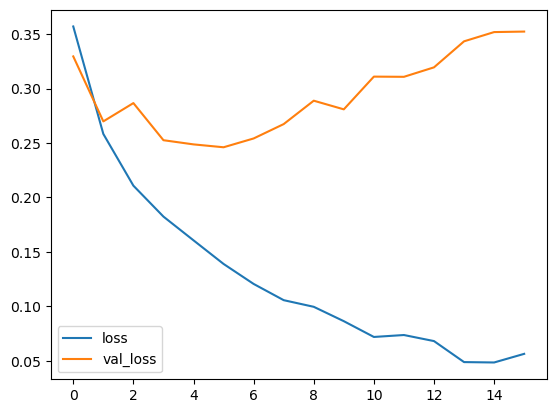

In [16]:
# Show the learning curves
import matplotlib
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

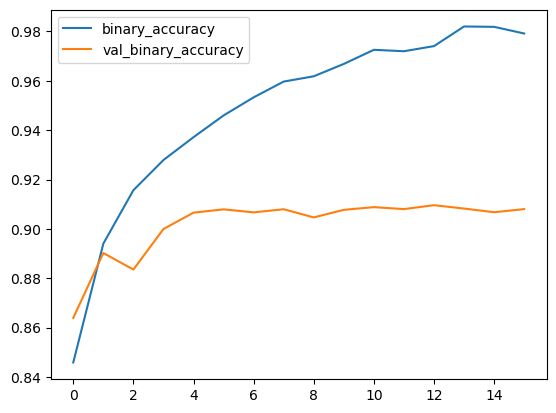

In [17]:
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [18]:
os.mkdir('model_08')

In [19]:
#saving history
history_df.to_csv('model_08/model_08.csv')

In [20]:
from keras.models import model_from_json

# Replace 'model' with the name of your trained model
model_name = 'model_08/model_08'

# Save the model architecture as a JSON file
model_json = model.to_json()
with open(model_name + '.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights as an H5 file
model.save_weights(model_name + '_weights.h5')

#saving complete model
model.save(model_name + '.h5')

In [21]:
X_train.shape

(240136, 1000, 21, 1)

In [ ]:
np.unique(y_val[:,1], return_counts=True)